# Acknowledgement
Dataset:https://www.kaggle.com/stefanlarson/outofscope-intent-classification-dataset

Context:

Most supervised machine learning tasks assume a dataset with a set of well-defined target label set. But what happens when a trained model meets the real world, where inputs to the trained model might not be from the well-defined target label set? This dataset offers a way to evaluate intent classification models on "out-of-scope" inputs.

"Out-of-scope" inputs are those that do not belong to the set of "in-scope" target labels. You may have heard other ways of referring to out-of-scope, including "out-of-domain" or "out-of-distribution".
Content

    is_*.json: these files house the train/val/test sets for the in-scope data. There are 150 in-scope "intents" (aka classes), which include samples such as "what is my balance" (which belongs to the balance class).
    oos_*.json: these files house the train/val/test sets for the out-of-scope data. There is one out-of-scope intent: oos. Note that you don't have to use the oos_train.json data. In other words, an ML solution to the out-of-scope problem need not be trained on out-of-scope data, but it might help!

Evaluation Metrics:

The task is intent classification, which generalizes to text classification (or categorization). This is a supervised ML problem. We use two metrics to evaluate:

    In-scope accuracy is defined as #(correctly classified in-scope samples) / #(in-scope samples).
    Out-of-scope recall is defined as #(correctly classified out-of-scope samples) / #(out-of-scope samples).

Acknowledgements:

This dataset is from An Evaluation Dataset for Intent Classification and Out-of-Scope Prediction by Larson et al., which was published in EMNLP in 2019. The GitHub page for this dataset is linked here.
Inspiration

Most supervised machine learning tasks assume a dataset with a set of well-defined target label set. But what happens when a trained model meets the real world, where inputs to the trained model might not be from the well-defined target label set? This "out-of-distribution" problem has seen lots of recent development, as researchers and practitioners in both academia and industry are observing that many ML methods struggle on out-of-distribution data in a wide variety of tasks.

# Import dependencies

In [1]:
import re
import os
import numpy as np 
import pandas as pd 
from sklearn.svm import SVC
import plotly.express as px
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import recall_score,precision_score,make_scorer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier,RUSBoostClassifier

pd.set_option('display.max_rows', 700)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/outofscope-intent-classification-dataset/oos_test.json
/kaggle/input/outofscope-intent-classification-dataset/is_train.json
/kaggle/input/outofscope-intent-classification-dataset/oos_val.json
/kaggle/input/outofscope-intent-classification-dataset/oos_train.json
/kaggle/input/outofscope-intent-classification-dataset/is_val.json
/kaggle/input/outofscope-intent-classification-dataset/is_test.json


# Load and clean data

In [2]:
train = pd.read_json('/kaggle/input/outofscope-intent-classification-dataset/is_train.json')
val = pd.read_json('/kaggle/input/outofscope-intent-classification-dataset/is_val.json')
test = pd.read_json('/kaggle/input/outofscope-intent-classification-dataset/is_test.json')
oos_train = pd.read_json('/kaggle/input/outofscope-intent-classification-dataset/oos_train.json')
oos_val = pd.read_json('/kaggle/input/outofscope-intent-classification-dataset/oos_val.json')
oos_test = pd.read_json('/kaggle/input/outofscope-intent-classification-dataset/oos_test.json')
files = [(train,'train'),(val,'val'),(test,'test'),(oos_train,'oos_train'),(oos_val,'oos_val'),(oos_test,'oos_test')]
for file,name in files:
    file.columns = ['text','intent']
    print(f'{name} shape:{file.shape}, {name} has {train.isna().sum().sum()} null values')
in_train = train.copy()

train shape:(15000, 2), train has 0 null values
val shape:(3000, 2), val has 0 null values
test shape:(4500, 2), test has 0 null values
oos_train shape:(100, 2), oos_train has 0 null values
oos_val shape:(100, 2), oos_val has 0 null values
oos_test shape:(1000, 2), oos_test has 0 null values


In [3]:
in_train.intent.value_counts()

gas                          100
who_do_you_work_for          100
pto_balance                  100
user_name                    100
timer                        100
how_old_are_you              100
credit_limit                 100
meaning_of_life              100
bill_due                     100
greeting                     100
travel_alert                 100
restaurant_reservation       100
pin_change                   100
roll_dice                    100
report_lost_card             100
confirm_reservation          100
recipe                       100
reminder_update              100
credit_limit_change          100
who_made_you                 100
w2                           100
how_busy                     100
lost_luggage                 100
time                         100
interest_rate                100
maybe                        100
update_playlist              100
cancel_reservation           100
weather                      100
cancel                       100
oil_change

All in-scope intents are balanced, no sampling required

Check if any text sampe has email,url,mention and hashtags

In [4]:
def ngrams_top(corpus,ngram_range,n=10):
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

def get_emails(x):
    email = re.findall(r'[\w\.-]+@[\w-]+\.[\w]+',str(x))
    return " ".join(email)
def get_urls(x):
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+\.[\w]+',str(x))
    return " ".join(url)
def get_mentions(x):
    mention = re.findall(r'(?<=@)\w+',str(x))
    return " ".join(mention)
def get_hashtags(x):
    hashtag = re.findall(r'(?<=#)\w+',str(x))
    return " ".join(hashtag)
def text_at_a_glance(df):
    res = df.apply(get_emails)
    res = res[res.values!=""]
    print("Data has {} rows with emails".format(len(res)))
    res = df.apply(get_urls)
    res = res[res.values!=""]
    print("Data has {} rows with urls".format(len(res)))
    res = df.apply(get_mentions)
    res = res[res.values!=""]
    print("Data has {} rows with mentions".format(len(res)))
    res = df.apply(get_hashtags)
    res = res[res.values!=""]
    print("Data has {} rows with hashtags".format(len(res)))

In [5]:
text_at_a_glance(in_train.text)

Data has 0 rows with emails
Data has 0 rows with urls
Data has 0 rows with mentions
Data has 1 rows with hashtags


In [6]:
#check where hashtag has been found, punctuations will be taken care of by vectorizer()
temp = in_train.text.apply(get_hashtags)
in_train.iloc[temp[temp.values!=""].index].text

13644    put mambo #5 by lou bega on my playlist, please
Name: text, dtype: object

# Ngrams

In [7]:
#top bigrams
bigrams = ngrams_top(in_train.text,(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#dc3912'],opacity=0.8,width=900,height=500)

In [8]:
#top trigrams
trigrams = ngrams_top(in_train.text,(3,3)).sort_values(by='count')
px.bar(data_frame=trigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#f58518'],opacity=0.8,width=900,height=500)

# In-scope prediction

In [9]:
def binarize(df):
    df.intent = np.where(df.intent!='oos',0,1)
    return df

def vectorizer(X):
    cv = CountVectorizer(min_df=1,ngram_range=(1,2))
    X_en = cv.fit_transform(X)
    return cv,X_en

def labelencoder(y):
    le = LabelEncoder()
    le.fit(y)
    y_enc = le.transform(y)
    return le,y_enc

def preprocess(train):
    X = train.text
    y = train.intent
    le,y = labelencoder(y)
    cv,X = vectorizer(X)
    return X,y,cv,le

def process_non_train(df,cv,le):
    X = df.text
    y = df.intent
    X = cv.transform(X)
    y = le.transform(y)
    return X,y

def get_score(clf,binary=0):
    clf.fit(X_train,y_train)
    if binary==1:
        y_pred = clf.predict(X_test)
        return clf,clf.score(X_val,y_val),clf.score(X_test,y_test),recall_score(y_test,y_pred),precision_score(y_test,y_pred)
    elif binary==0:
        return clf,clf.score(X_val,y_val),clf.score(X_test,y_test)

In [10]:
X_train,y_train,cv,le = preprocess(in_train)
X_val,y_val = process_non_train(val,cv,le)
X_test,y_test = process_non_train(test,cv,le)

### Evaluate data over models

In [11]:
val_scores = []
test_scores = []
names = []

models = [(KNeighborsClassifier(n_neighbors=15),'KNN'),(SGDClassifier(),'SGD clf'),(MultinomialNB(),'MultinomialNB'),
          (RandomForestClassifier(),'Random Forest'),(SVC(kernel='linear'),'Linear SVC')]

for model,name in models:
    clf,score,test_score = get_score(model,0)
    names.append(name)
    val_scores.append(score*100)
    test_scores.append(test_score*100)
pd.DataFrame(data=zip(val_scores,test_scores),index=names,columns=['val_score','test_score']).style.background_gradient()

,val_score,test_score
KNN,48.266667,47.533333
SGD clf,90.533333,90.600000
MultinomialNB,84.833333,85.488889
Random Forest,86.800000,86.888889
Linear SVC,87.933333,87.266667


In [12]:
params = {
    'loss':['squared_hinge','modified_huber'],
    'alpha':[0.0001,0.001,0.01],
    'max_iter':[250,500,1000],
    'validation_fraction':[0.2]
}
cv = GridSearchCV(SGDClassifier(random_state=111),param_grid=params, cv=5,n_jobs=-1,verbose=2)

In [13]:
cv.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=111, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'loss': ['squared_hinge', 'modified_huber'],
                         'max_iter': [250, 500, 1000],
                         'vali

In [14]:
cv.best_params_

{'alpha': 0.001,
 'loss': 'modified_huber',
 'max_iter': 250,
 'validation_fraction': 0.2}

In [15]:
cv.best_score_

0.9207333333333333

# In-Scope and Out-Scope classification (binary)

To perform in and out scope classification we have to encode all samples with intent features other than 'oos' to 0 and with 'oos' to 1 which will be done by binarize()

In [16]:
oos_plus_train = binarize(pd.concat([in_train,oos_train],axis=0).reset_index(drop=True))
oos_plus_val = binarize(pd.concat([val,oos_val],axis=0).reset_index(drop=True))
oos_plus_test = binarize(pd.concat([test,oos_test],axis=0).reset_index(drop=True))

In [17]:
oos_count = oos_plus_train.intent.value_counts()
oos_count

0    15000
1      100
Name: intent, dtype: int64

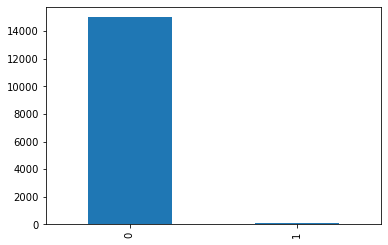

In [18]:
oos_count.plot(kind='bar')

The imbalance ratio between 0 and 1 is 150

This imbalance can be dealt with by using sampling, here I will be using undersampling i.e the majority class will be undersampled to the size of minority class, coupling this with ensembling will give us best results.

Resources:

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data/

In [19]:
X_train,y_train,cv,le = preprocess(oos_plus_train)
X_val,y_val = process_non_train(oos_plus_val,cv,le)
X_test,y_test = process_non_train(oos_plus_test,cv,le)

In [20]:
val_scores = []
test_scores = []
recall = []
names = []
precision = []

models = [(BalancedRandomForestClassifier(sampling_strategy='not minority',random_state=111),'Balanced Random Forest'),
          (RUSBoostClassifier(base_estimator=LogisticRegression(),sampling_strategy='not minority',random_state=111),'Random Undersampling + Adaboost'),
          (EasyEnsembleClassifier(n_estimators=30,base_estimator=LogisticRegression(),replacement=True,sampling_strategy='not minority',random_state=111),'Easy Ensemble')]

for model,name in models:
    _,score,test_score,recall_sc,precision_sc = get_score(model,1)
    names.append(name)
    val_scores.append(score*100)
    test_scores.append(test_score*100)
    recall.append(recall_sc*100)
    precision.append(precision_sc*100)
pd.DataFrame(data=zip(val_scores,test_scores,recall,precision),index=names,
             columns=['val_score','test_score','recall_score','precision_score']).style.background_gradient()

,val_score,test_score,recall_score,precision_score
Balanced Random Forest,53.225806,54.618182,71.700000,24.470990
Random Undersampling + Adaboost,76.612903,71.472727,47.600000,31.295201
Easy Ensemble,77.645161,72.690909,49.800000,33.244326


Balanced Random Forest:

Accuracy 😪

recall 🤩

precision 😑

Easy ensemble has provided the best performance, next step is to explore easyensemble more

Learn more about easyensemble:

X. Y. Liu, J. Wu and Z. H. Zhou, “Exploratory Undersampling for Class-Imbalance Learning,” in IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 39, no. 2, pp. 539-550, April 2009.

### Tuning EasyEnsemble

In [21]:
params = {
    'n_estimators':[30,50,70],
    'base_estimator':[AdaBoostClassifier(),LogisticRegression()],
    'replacement':[False,True]
}
cv = GridSearchCV(EasyEnsembleClassifier(n_jobs=-1,sampling_strategy='not minority',random_state=111),
                  verbose=2,
                  scoring='recall',
                  param_grid=params, cv=5,
                  n_jobs=-1)
cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=EasyEnsembleClassifier(base_estimator=None,
                                              n_estimators=10, n_jobs=-1,
                                              random_state=111,
                                              replacement=False,
                                              sampling_strategy='not minority',
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'base_estimator': [AdaBoostClassifier(algorithm='SAMME.R',
                                                               base_estimator=None,
                                                               learning_rate=1.0,
                                                               n_estima...
                                                               class_weight=None,
                                                               dual=False,
              

In [22]:
cv.best_score_

0.8400000000000001

In [23]:
cv.best_params_

{'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'n_estimators': 50,
 'replacement': False}

### Tune base estimator of EasyEnsemble

In [24]:
n_estimator = [25,50,100]
learning_rate=[0.001,0.0001]
result = []
for nest in n_estimator:
    for lr in learning_rate:
        eec = EasyEnsembleClassifier(base_estimator=AdaBoostClassifier(n_estimators=nest,learning_rate=lr)
                                     ,n_estimators=100,
                                     replacement=True,n_jobs=-1,
                                     sampling_strategy='not minority',random_state=111)
        eec.fit(X_train,y_train)
        recall = recall_score(y_test,eec.predict(X_test))
        result.append([nest,lr,recall])

In [25]:
pd.DataFrame(result,columns=['n_estimators','learning_rate','recall_score']).style.background_gradient(subset=['recall_score'])

,n_estimators,learning_rate,recall_score
0,25,0.001000,0.801000
1,25,0.000100,0.801000
2,50,0.001000,0.801000
3,50,0.000100,0.801000
4,100,0.001000,0.801000
5,100,0.000100,0.801000


# Thank you for coming by, suggest modifications if any